<center>
    <h3>Arnaud Ch√©ridi</h3>
    <p>√âtudiant en Master 2 Math√©matiques Appliqu√©es</p>
    <p>Projet individuel : Mod√©lisation du risque de cr√©dit (cas IFRS 9)</p>
    <p>Objectif : d√©velopper un mod√®le de PD (score > 65%) + LGD + simulation</p>
</center>

<center><h2> 4. Simulation de l'Exposition au moment du d√©faut <h2><center>

## Contexte

Apr√®s avoir s√©lectionn√© et calibr√© des mod√®les pour estimer les probabilit√©s de d√©faut (`PD`) et les pertes en cas de d√©faut (`LGD`) √† partir d‚Äôun jeu de donn√©es cr√©dit, nous poursuivons notre analyse du risque de cr√©dit en simulant trois grandeurs fondamentales dans le cadre de la norme IFRS 9 :

- **EAD (Exposure at Default)** : Exposition attendue au moment du d√©faut, c‚Äôest-√†-dire le montant encore d√ª au moment o√π le client fait d√©faut.
- **EAC (Expected Annualized Cost)** : Perte attendue ponctuelle √† un instant donn√©, calcul√©e sur les flux de remboursement mensuels.
- **ECL (Expected Credit Loss)** : Perte attendue totale si le d√©faut survient √† un instant donn√©, en tenant compte de l‚Äôensemble de l‚Äôencours restant.

Ces simulations s‚Äôinscrivent dans une logique prospective de type "lifetime expected loss" et permettent de mieux quantifier l‚Äô√©volution du risque dans le temps.

---

## Objectifs

L‚Äôobjectif de cette √©tape est de :

- Simuler, **mois par mois**, la dynamique du portefeuille de cr√©dits,
- Reproduire l'entr√©e en d√©faut al√©atoire des clients, bas√©e sur leur `PD`,
- Calculer √† chaque pas de temps :
  - l‚Äô**EAD** : somme des encours restants des clients **au moment o√π ils font d√©faut**,
  - l‚Äô**EAC** : perte attendue instantan√©e, calcul√©e comme `PD √ó LGD √ó remboursement_mensuel`,
  - l‚Äô**ECL** : perte attendue totale, calcul√©e comme `PD √ó LGD √ó encours restant` pour chaque client actif,
- R√©p√©ter ce processus via une **simulation Monte Carlo**, pour obtenir une estimation robuste de l‚Äô√©volution dans le temps du risque,
- Visualiser l‚Äôincertitude par une **moyenne et une bande de confiance** autour des trajectoires.

---

## M√©thodologie

1. **Initialisation** :
   - On duplique le dataset original, en ajoutant des colonnes `defaulted` (bool√©en), `mois_defaut` (entier), `ead_defaut` (float).

2. **Simulation temporelle (mois par mois)** :
   - Chaque mois, pour chaque client encore actif :
     - On tire un uniforme $U \sim \mathcal{U}(0,1)$,
     - Si $U < \text{PD}$, le client entre en **d√©faut** √† ce mois.
   - On marque les d√©fauts et on les exclut des mois suivants.

3. **Calcul des indicateurs** :
   - `EAD(t)` : somme des montants encore dus par les clients **ayant fait d√©faut** √† $t$,
   - `EAC(t)` : somme des pertes attendues sur les **flux mensuels** (encore actifs),
   - `ECL(t)` : somme des pertes attendues sur les **encours restants** (encore actifs), i.e. $PD \times LGD \times EAD(t)$.
   >**Hypoth√®se simplificatrice** : les simulations sont r√©alis√©es **hors taux d‚Äôint√©r√™t**. On suppose que les remboursements mensuels et les encours ne sont pas actualis√©s. Cela revient √† consid√©rer une approximation en valeur nominale des flux.

4. **Monte Carlo (N simulations)** :
   - Le processus est r√©p√©t√© $N$ fois (par exemple $N = 1000$),
   - √Ä chaque it√©ration, on stocke `EAD(t)`, `EAC(t)`, et `ECL(t)` sur l‚Äôhorizon de simulation,
   - On extrait ensuite la **moyenne**, l‚Äô**√©cart-type**, et les **bandes de confiance**.

---

## R√©sultat attendu

Les graphiques finaux permettent de visualiser :
- L‚Äô√©volution moyenne de l‚Äô**exposition au risque** (`EAD`),
- Le **co√ªt du risque mensuel** (`EAC`), et la **perte attendue totale** (`ECL`) dans le temps,
- L‚Äôimpact de l‚Äôal√©a de d√©faut sur les flux futurs,
- L‚Äôincertitude du portefeuille via les bandes $\pm 2\sigma$ autour de la moyenne.

---

> Ces simulations permettent de mieux anticiper les pertes attendues sur un portefeuille de cr√©dits, d‚Äôaffiner le provisionnement IFRS 9, et de structurer des exercices de stress testing ou d‚Äôallocation de capital √©conomique.

## 0. Import des biblioth√®ques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

import joblib

## 1. Chargement des donn√©es et des mod√®les

In [2]:
train_final = pd.read_csv("data/train_final.csv")
test_final = pd.read_csv("data/test_final.csv")
full_df = pd.concat([train_final, test_final], axis=0)

df = full_df.drop(columns=["TARGET", "SK_ID_CURR", "LGD_sim", "LGD_sim_NA"])

model_pd = joblib.load("model_pd.pkl")
model_lgd = joblib.load("model_lgd.pkl")

## 2. Calcul de la PD et de LGD avec nos mod√®les et calcul

In [3]:
df["PD"] = model_pd.predict_proba(df)[:,1]
df["LGD"] = model_lgd.predict(df.drop(columns=["PD"]))

/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


- `duree_credit_mois` : estimation de la **dur√©e du cr√©dit en mois**, en supposant que le montant total des revenus sert √† rembourser l'annuit√©.
- `remboursement_mensuel` : estimation du **montant mensuel rembours√©**

In [5]:
df["duree_credit_mois"] = (df["AMT_INCOME_TOTAL"]/df["AMT_ANNUITY"]*12).astype(int)
df["remboursement_mensuel"] = df["AMT_ANNUITY"]/12

Dans le dataset, la variable `PD` repr√©sente la **probabilit√© cumul√©e de d√©faut sur toute la dur√©e du cr√©dit**, c‚Äôest-√†-dire la probabilit√© qu‚Äôun client fasse d√©faut √† un moment quelconque avant la fin de son contrat.

Pour simuler le risque **mois par mois** dans un cadre dynamique (ex : simulation de d√©fauts ou de flux en Monte Carlo), nous devons convertir cette probabilit√© globale en une **probabilit√© conditionnelle de d√©faut par p√©riode mensuelle**.

La formule utilis√©e est issue de l‚Äôhypoth√®se d‚Äôind√©pendance temporelle des d√©fauts :
$\text{PD}_{\text{mensuelle}} = 1 - (1 - \text{PD}_{\text{totale}})^{1 / \text{dur√©e\_mois}}$

Cette relation suppose que la probabilit√© de **survie jusqu'√† la fin du cr√©dit** est √©gale au produit des probabilit√©s de survie √† chaque mois, ce qui revient √† r√©partir le risque de mani√®re constante dans le temps.

>**Remarque** : Cette transformation est couramment utilis√©e lorsque l‚Äôon simule des √©v√©nements de d√©faut de mani√®re it√©rative dans le temps (ex : tirages mensuels avec une loi uniforme).

In [6]:
def convertir_pd_mensuelle(pd_totale, duree_mois):
    return 1 - (1 - pd_totale)**(1 / duree_mois)

# Application vectorielle
df["pd_mensuelle"] = convertir_pd_mensuelle(df["PD"], df["duree_credit_mois"])

## 3. Mise en place des planchers

Les planchers suivants sont appliqu√©s conform√©ment aux exigences **r√©glementaires (IFRS 9 / B√¢le II/III)** :

- **Probabilit√© de d√©faut minimale (PD)** :
  - *Cash loans* : 0.05 % (`0.0005`)
  - *Revolving loans* : 0.10 % (`0.001`)

- **Loss Given Default minimale (LGD)** :
  - *Cash loans* : 15 % (`0.15`)
  - *Revolving loans* : 70 % (`0.70`)

Ces **valeurs minimales** sont impos√©es pour √©viter une sous-estimation excessive du risque de cr√©dit.

In [7]:
plancher_pd = {
    'Cash loans': 0.0005,       # 0.05%
    'Revolving loans': 0.001    # 0.10%
}

plancher_lgd = {
    'Cash loans': 0.15,         # 15%
    'Revolving loans': 0.70     # 70%
}

In [8]:
# Fonction d'ajustement des valeurs plancher
def appliquer_planchers(row):
    type_credit = row['NAME_CONTRACT_TYPE']
    row['PD'] = max(row['PD'], plancher_pd.get(type_credit, 0))
    row['LGD'] = max(row['LGD'], plancher_lgd.get(type_credit, 0))
    return row

# Application au DataFrame
df = df.apply(appliquer_planchers, axis=1)

## 4. Simulation de l'EAC, l'EAD et l'ECL

## Objectif de la simulation Monte Carlo

L‚Äôobjectif de cette simulation est d‚Äôestimer dynamiquement l‚Äô√©volution des indicateurs de risque li√©s √† un portefeuille de cr√©dits, en tenant compte de l‚Äôincertitude de d√©faut. Plus pr√©cis√©ment, on calcule √† chaque pas de temps :

- **l‚ÄôEAD au moment du d√©faut** : `ead_defaut_montecarlo`
- **la perte attendue mensuelle (EAC)** : `eac_montecarlo`
- **la perte attendue totale (ECL)** : `ecl_montecarlo`
- **l‚Äôencours encore actif** dans le portefeuille : `encours_total_montecarlo`

Le processus est r√©p√©t√© **M = 1000 fois** (simulation de Monte Carlo), mois par mois, jusqu‚Äô√† la dur√©e maximale observ√©e (`temps_max`).

---

### D√©roul√© d‚Äôune simulation unique

√Ä chaque simulation, on r√©p√®te la proc√©dure suivante :

- Pour chaque client encore actif :
  - On **tire un uniforme** $U \sim \mathcal{U}(0,1)$,
  - Si $U < \text{PD}$, le client **entre en d√©faut** ce mois-ci,
  - On enregistre alors :
    - Le **mois du d√©faut**
    - L‚Äô**exposition au moment du d√©faut** :
      $\text{EAD}_i(t) = (\text{dur√©e restante}) \times \text{remboursement mensuel}$

- Pour chaque mois \( t \), on calcule :

  - **EAD au d√©faut** :
    $\text{EAD}_t = \sum_{\text{clients en d√©faut √† } t} \text{EAD}_i(t)$

  - **EAC (perte attendue sur flux)** :
    $\text{EAC}_t = \sum_{\text{clients actifs}} \text{PD}_i(t) \cdot \text{LGD}_i \cdot \text{remboursement mensuel}_i$

  - **ECL (perte attendue sur encours)** :
    $\text{ECL}_t = \sum_{\text{clients actifs}} \text{PD}_i(t) \cdot \text{LGD}_i \cdot \text{EAD th√©orique}_i(t)$

  - **Encours vivant** :
    $\text{Encours}_t = \sum_{\text{clients actifs}} \text{dur√©e restante} \times \text{remboursement mensuel}


---

> Ces donn√©es sont ensuite agr√©g√©es (moyenne, quantiles) sur les 100 (afin de limiter les co√ªts computationnels) simulations afin de visualiser l‚Äô√©volution moyenne, la volatilit√© et les sc√©narios extr√™mes du risque de cr√©dit dans le portefeuille.

In [9]:
def simulation_montecarlo(temps_max):
    df_sim = df.copy()
    df_sim["defaulted"] = False
    df_sim["mois_defaut"] = np.nan
    df_sim["ead_defaut"] = 0.0

    ead_defaut_vec = np.zeros(temps_max)   # R√©alis√© (clients qui font d√©faut √† t)
    eac_vec = np.zeros(temps_max)          # Esp√©rance sur flux
    ecl_vec = np.zeros(temps_max)          # Esp√©rance sur encours
    encours_vec = np.zeros(temps_max)      # Encours restant du

    for mois in range(temps_max):
        # Clients encore actifs
        actifs = df_sim[(~df_sim["defaulted"]) & (df_sim["duree_credit_mois"] > mois)]

        # Tirage al√©atoire : simulation de d√©faut
        tirages = np.random.uniform(0, 1, len(actifs))
        defaut = tirages < actifs["pd_mensuelle"].values
        index_defaut = actifs[defaut].index

        # Marquer les d√©fauts
        df_sim.loc[index_defaut, "defaulted"] = True
        df_sim.loc[index_defaut, "mois_defaut"] = mois

        # Calcul de l‚ÄôEAD au d√©faut pour les clients d√©faillants √† t
        ead_defaut = ((df_sim.loc[index_defaut, "duree_credit_mois"] - mois) *
                      df_sim.loc[index_defaut, "remboursement_mensuel"])
        df_sim.loc[index_defaut, "ead_defaut"] = ead_defaut
        ead_defaut_vec[mois] = ead_defaut.sum()

        # EAC = PD √ó LGD √ó mensualit√© (esp√©rance sur flux)
        eac_mois = (actifs["pd_mensuelle"] * actifs["LGD"] * actifs["remboursement_mensuel"]).sum()
        eac_vec[mois] = eac_mois

        # ECL = PD √ó LGD √ó EAD th√©orique (esp√©rance sur encours restant)
        ead_theorique = (actifs["duree_credit_mois"] - mois) * actifs["remboursement_mensuel"]
        ecl_mois = (actifs["pd_mensuelle"] * actifs["LGD"] * ead_theorique).sum()
        ecl_vec[mois] = ecl_mois

        # Encours restant d√ª pour les clients encore actifs
        encours_mois = ((actifs["duree_credit_mois"] - mois) * actifs["remboursement_mensuel"]).sum()
        encours_vec[mois] = encours_mois

    return ead_defaut_vec, eac_vec, ecl_vec, encours_vec

In [10]:
N = 100  # nombre de simulations
temps_max = 60 # horizon max

results = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(simulation_montecarlo)(temps_max) for _ in range(N))

ead_defaut_montecarlo = np.array([res[0] for res in results])
eac_montecarlo = np.array([res[1] for res in results])
ecl_montecarlo = np.array([res[2] for res in results])
encours_montecarlo = np.array([res[3] for res in results])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.1min
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:  4.4min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


In [11]:
# Moyenne et bande ¬±2œÉ
ead_mean = ead_defaut_montecarlo.mean(axis=0)
ead_std = ead_defaut_montecarlo.std(axis=0)

eac_mean = eac_montecarlo.mean(axis=0)
eac_std = eac_montecarlo.std(axis=0)

ecl_mean = ecl_montecarlo.mean(axis=0)
ecl_std = ecl_montecarlo.std(axis=0)

encours_mean = encours_montecarlo.mean(axis=0)
encours_std = encours_montecarlo.std(axis=0)

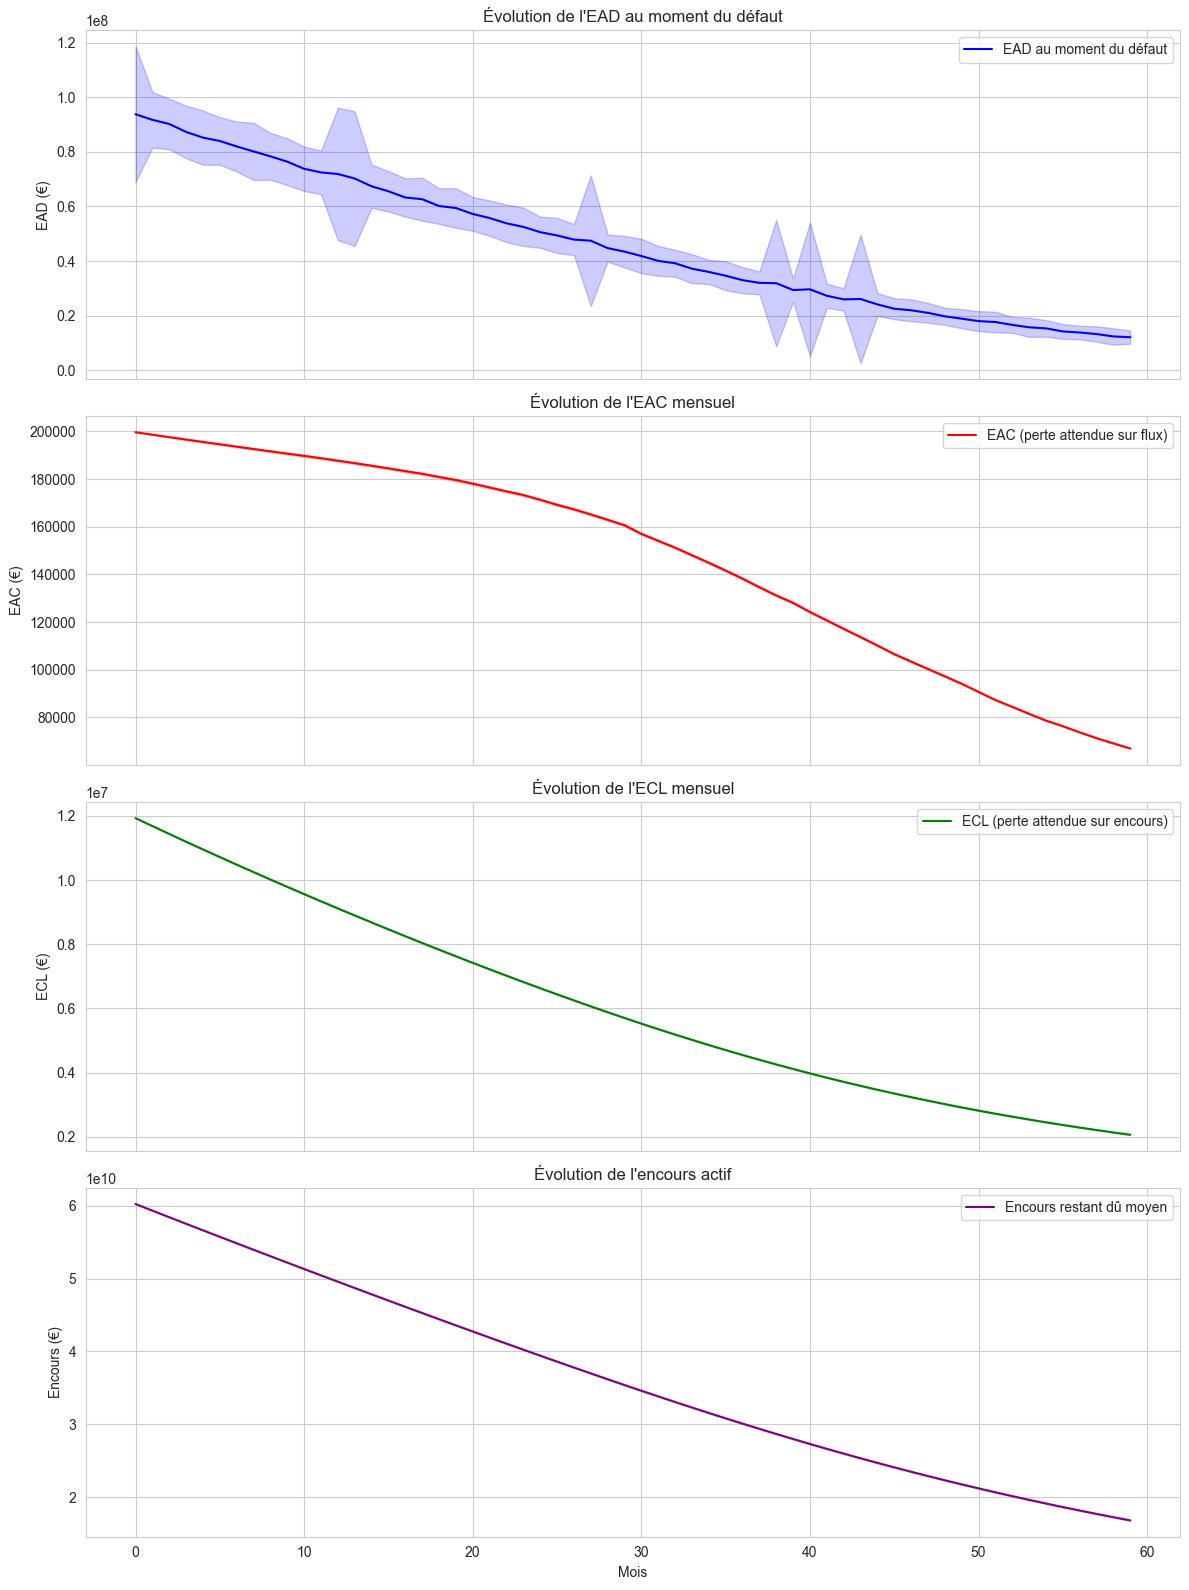

In [12]:
# Cr√©ation du subplot (4 lignes d√©sormais)
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# --- EAD au d√©faut
axes[0].plot(ead_mean, label="EAD au moment du d√©faut", color='blue')
axes[0].fill_between(range(temps_max), ead_mean - 2*ead_std, ead_mean + 2*ead_std, alpha=0.2, color='blue')
axes[0].set_ylabel("EAD (‚Ç¨)")
axes[0].set_title("√âvolution de l'EAD au moment du d√©faut")
axes[0].legend()
axes[0].grid(True)

# --- EAC
axes[1].plot(eac_mean, label="EAC (perte attendue sur flux)", color='red')
axes[1].fill_between(range(temps_max), eac_mean - 2*eac_std, eac_mean + 2*eac_std, alpha=0.2, color='red')
axes[1].set_ylabel("EAC (‚Ç¨)")
axes[1].set_title("√âvolution de l'EAC mensuel")
axes[1].legend()
axes[1].grid(True)

# --- ECL
axes[2].plot(ecl_mean, label="ECL (perte attendue sur encours)", color='green')
axes[2].fill_between(range(temps_max), ecl_mean - 2*ecl_std, ecl_mean + 2*ecl_std, alpha=0.2, color='green')
axes[2].set_ylabel("ECL (‚Ç¨)")
axes[2].set_title("√âvolution de l'ECL mensuel")
axes[2].legend()
axes[2].grid(True)

# --- Encours restant d√ª
encours_mean = encours_montecarlo.mean(axis=0)
encours_std = encours_montecarlo.std(axis=0)

axes[3].plot(encours_mean, label="Encours restant d√ª moyen", color='purple')
axes[3].fill_between(range(temps_max), encours_mean - 2*encours_std, encours_mean + 2*encours_std, alpha=0.2, color='purple')
axes[3].set_ylabel("Encours (‚Ç¨)")
axes[3].set_xlabel("Mois")
axes[3].set_title("√âvolution de l'encours actif")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

## Analyse des r√©sultats simul√©s ‚Äì Monte Carlo (100 trajectoires)

Les graphiques ci-dessous pr√©sentent l‚Äô√©volution moyenne de quatre indicateurs cl√©s de la mod√©lisation du risque de cr√©dit, simul√©s sur 100 trajectoires Monte Carlo :

- l‚Äô**EAD au moment du d√©faut** (bleu),
- l‚Äô**EAC mensuel** (rouge),
- l‚Äô**ECL mensuel** (vert),
- l‚Äô**encours restant d√ª** (violet).

---

### 1. √âvolution de l‚ÄôEAD au moment du d√©faut

- L‚Äô**exposition au moment du d√©faut** d√©cro√Æt dans le temps, passant de ~110M‚Ç¨ √† moins de 20M‚Ç¨ apr√®s 60 mois.
- La courbe d√©cro√Æt globalement de mani√®re **quasi-lin√©aire**, avec quelques fluctuations dues √† l‚Äôal√©a du d√©faut (bandes bleues).
- Cela refl√®te le fait que **moins de clients restent expos√©s** au fil du temps, car certains remboursent, d‚Äôautres font d√©faut.

**üí° Interpr√©tation** : le risque de d√©faut porte sur un encours d√©croissant, ce qui r√©duit m√©caniquement l‚Äôexposition moyenne en cas de d√©faut.

---

### 2. √âvolution de l‚ÄôEAC (Expected Accrued Cost)

- L‚Äô**EAC mensuel** chute progressivement, partant d‚Äôenviron 200‚ÄØ000‚ÄØ‚Ç¨ √† moins de 90‚ÄØ000‚ÄØ‚Ç¨.
- Cela refl√®te la **perte attendue sur les flux mensuels**, proportionnelle √† `PD √ó LGD √ó remboursement`.

**üí° Interpr√©tation** : cette d√©croissance lente refl√®te la disparition progressive des cr√©dits actifs (portefeuille ferm√©) et donc des flux √† risque.

---

### 3. √âvolution de l‚ÄôECL (Expected Credit Loss)

- L‚ÄôECL, repr√©sentant la **perte attendue sur encours**, suit une courbe descendante allant de ~12M‚Ç¨ √† moins de 3M‚Ç¨.
- Il traduit la **valeur actuelle du risque de cr√©dit r√©siduel** en cas de d√©faut imm√©diat.

**üí° Interpr√©tation** : l‚Äôencours pond√©r√© par le risque diminue dans le temps, refl√©tant la r√©duction progressive du portefeuille et la s√©lection des emprunteurs les plus solides.

---

### 4. √âvolution de l‚Äôencours actif

- L‚Äô**encours restant d√ª** passe de 6 milliards ‚Ç¨ √† ~1,2 milliard ‚Ç¨ en 60 mois.
- Cette d√©croissance lin√©aire illustre l‚Äôamortissement progressif des cr√©dits (effet combin√© des remboursements et des d√©fauts).

**üí° Interpr√©tation** : le portefeuille est ferm√© (pas de nouveaux pr√™ts), ce qui explique la r√©duction m√©canique de l'encours dans le temps.

---

## Interpr√©tation √©conomique globale

Ces r√©sultats confirment un comportement classique dans un portefeuille de cr√©dit :

- Le **risque est concentr√© en d√©but de vie** du contrat,
- Les d√©fauts interviennent souvent t√¥t, sur des encours importants,
- L‚ÄôEAC baisse rapidement, signalant la diminution du flux √† risque,
- L‚ÄôECL reste significatif plus longtemps, car l‚Äôencours total amortit lentement.

### Implications pour la gestion du risque :

- Les banques doivent **provisionner fortement en d√©but de cr√©dit** (exigence IFRS 9 Stage 1),
- Il est crucial d‚Äô**anticiper les pertes attendues sur encours et flux** d√®s l‚Äôoctroi,
- L‚Äôanalyse dynamique du risque permet une **meilleure planification du capital** √† risque et des buffers prudentiels.